In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import corner
from models.classifier import BinaryClassifier
import torch
from torch.utils.data import TensorDataset
from tqdm.auto import trange
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from models.flow import Flow
from models.fair import BinaryFair
from sklearn.manifold import TSNE
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from models.galton import Galton


In [2]:
n_steps_big = 30
n_steps_small = 5
n_balls = 1.e4
g_big = Galton(n_steps=n_steps_big, odds_right=0.5, n_dims=1)
g_small = Galton(n_steps=n_steps_small, odds_right=0.6, n_dims=1)
pos_big = g_big.simulate(n_balls=n_balls)
pos_small = g_small.simulate(n_balls=n_balls)

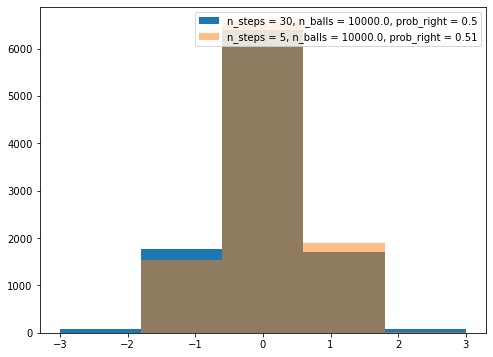

In [96]:
bins = np.linspace(-3,3,6)
plt.figure(figsize=(8,6))
plt.hist(pos_big, bins=bins,label="n_steps = {}, n_balls = {}, prob_right = {}".format(n_steps_big, n_balls_big, g_big.odds_right))
plt.hist(pos_small, bins=bins, label="n_steps = {}, n_balls = {}, prob_right = {}".format(n_steps_small, n_balls_small, g_small.odds_right), alpha=0.5)
plt.legend()
plt.show()

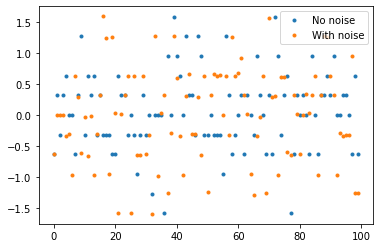

In [4]:
#Generate with noise
g = Galton(n_steps=10, odds_right=0.5, n_dims=1, sigma=0)
g_noise = Galton(n_steps=10, odds_right=0.5, n_dims=1, noise=True)
pos = g.simulate(n_balls=100)
pos_noise = g_noise.simulate(n_balls=100)
plt.plot(pos, ".", label="No noise")
plt.plot(pos_noise, ".", label="With noise")
plt.legend()
plt.show()

## Binary Classifier

In [5]:
Nsims = 100

n_balls_big = 1.e2
n_balls_small = 1.e2

pos_big_arr = np.array([g_big.simulate(n_balls=n_balls_big) for _ in range(Nsims)])
pos_small_arr = np.array([g_small.simulate(n_balls=n_balls_small) for _ in range(Nsims)])

In [6]:
data = torch.cat((torch.from_numpy(pos_big_arr).float().reshape(-1,1), torch.from_numpy(pos_small_arr).float().reshape(-1,1)))
labels = torch.cat([torch.zeros(pos_big_arr.shape[0]*pos_big_arr.shape[1]), torch.ones(pos_small_arr.shape[0]*pos_small_arr.shape[1])])
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 

In [7]:
# Parameters
params = {'batch_size': 512,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, labels_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

# data_set_test = TensorDataset(data_test, labels_test)
# data_generator_test = torch.utils.data.DataLoader(data_set_test, **params)

In [8]:
# classifier = BinaryClassifier(np.shape(pos_big_arr)[1])
classifier = BinaryClassifier(1)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-4)

In [9]:
n_steps = 1000
classifier_loss = []

classifier.train()
for n_step in trange(n_steps):
    data, labels = next(iter(data_generator_train))
    
    optimizer.zero_grad()

    loss = classifier.loss(data, labels).mean()
    classifier_loss.append(loss.item())

    loss.backward()
    optimizer.step()
classifier.eval();

100%|██████████| 1000/1000 [00:03<00:00, 264.84it/s]


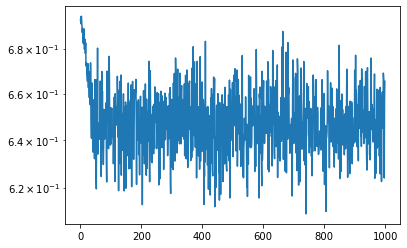

In [10]:
plt.plot(classifier_loss)
plt.yscale('log')

## Classifier Picking up on unfairness

In [11]:
odds_arr = [0.5, 0.51, 0.55, 0.7]
Nsims = 100
n_balls = 1.e2
n_steps = 1000
accuracy_score_arr = []

for odds in odds_arr:
    g_big = Galton(n_steps=10, odds_right=0.5, n_dims=1) #Don't need to re-initialize this but w/e
    g_small = Galton(n_steps=10, odds_right=odds, n_dims=1)
    pos_big_arr = np.array([g_big.simulate(n_balls=n_balls) for _ in range(Nsims)])
    pos_small_arr = np.array([g_small.simulate(n_balls=n_balls_small) for _ in range(Nsims)])

    data = torch.cat((torch.from_numpy(pos_big_arr).float().reshape(-1,1), torch.from_numpy(pos_small_arr).float().reshape(-1,1)))
    labels = torch.cat([torch.zeros(pos_big_arr.shape[0]*pos_big_arr.shape[1]), torch.ones(pos_small_arr.shape[0]*pos_small_arr.shape[1])])
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 

    data_set_train = TensorDataset(data_train, labels_train)
    data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

    classifier = BinaryClassifier(1, activation="ReLU")
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-2, weight_decay=1e-4) 
    
    classifier.train()
    classifier_loss=[]
    for n_step in trange(n_steps):
        data, labels = next(iter(data_generator_train))
        
        optimizer.zero_grad()

        loss = classifier.loss(data, labels).mean()
        classifier_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    classifier.eval();
    accuracy_score_arr.append(((classifier.forward(data_test) > 0.0) == labels_test).float().mean())
    

100%|██████████| 1000/1000 [00:03<00:00, 281.80it/s]


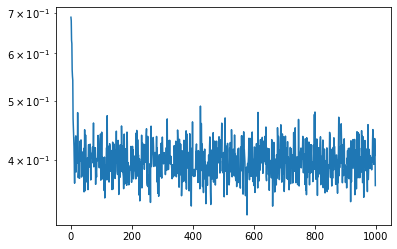

In [12]:
plt.plot(classifier_loss)
plt.yscale('log')

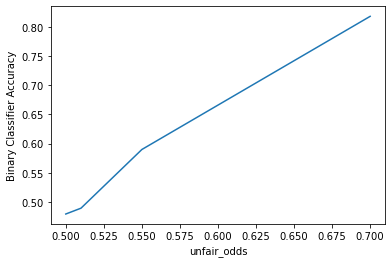

In [14]:
plt.plot(odds_arr, accuracy_score_arr)
plt.xlabel("unfair_odds")
plt.ylabel("Binary Classifier Accuracy")
plt.show()

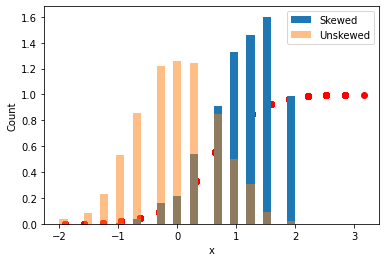

In [15]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,30), label="Skewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,30),alpha=0.5, label="Unskewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), classifier.forward(data_test).sigmoid().detach().numpy(), color="red")

## Classifier finding resolution

In [16]:
params = {'batch_size': 256,
          'shuffle': True}

In [17]:
n_rows_arr = [5, 10, 100, 500]
n_rows_low = 5
Nsims = 100
n_balls = 1e2
accuracy_score_arr = []
n_steps = 2000

for n_rows in n_rows_arr:
    g_big = Galton(n_steps=n_rows_low, odds_right=0.5, n_dims=1) 
    g_small = Galton(n_steps=n_rows, odds_right=0.5, n_dims=1)
    
    pos_big_arr = np.array([g_big.simulate(n_balls=n_balls) for _ in range(Nsims)])
    pos_small_arr = np.array([g_small.simulate(n_balls=n_balls) for _ in range(Nsims)])

    data = torch.cat((torch.from_numpy(pos_big_arr).float().reshape(-1,1), torch.from_numpy(pos_small_arr).float().reshape(-1,1)))
    labels = torch.cat([torch.zeros(pos_big_arr.shape[0]*pos_big_arr.shape[1]), torch.ones(pos_small_arr.shape[0]*pos_small_arr.shape[1])])
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 

    data_set_train = TensorDataset(data_train, labels_train)
    data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

    classifier = BinaryClassifier(1,activation="ReLU")
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-4) 
    
    classifier.train()
    classifier_loss = []
    for n_step in trange(n_steps):
        data, labels = next(iter(data_generator_train))
        
        optimizer.zero_grad()

        loss = classifier.loss(data, labels).mean()
        classifier_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    classifier.eval();
    accuracy_score_arr.append(((classifier.forward(data_test) > 0.0) == labels_test).float().mean())
    

100%|██████████| 2000/2000 [00:04<00:00, 438.85it/s]


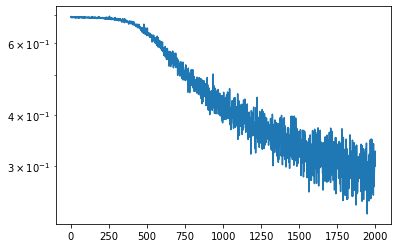

In [18]:
plt.plot(classifier_loss)
plt.yscale('log')

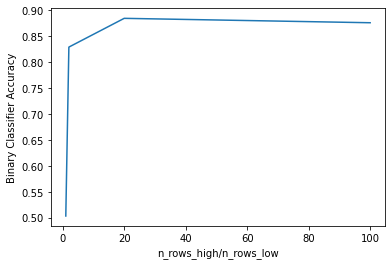

In [19]:
plt.plot(np.array(n_rows_arr)/5.0, accuracy_score_arr)
plt.xlabel("n_rows_high/n_rows_low")
plt.ylabel("Binary Classifier Accuracy")
plt.show()

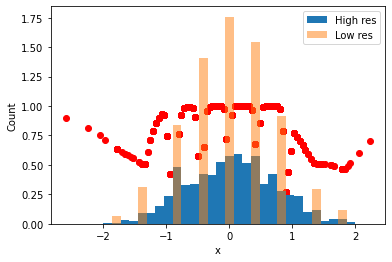

In [22]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,30), label="High res", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,30),alpha=0.5, label="Low res", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), classifier.forward(data_test).sigmoid().detach().numpy(), color="red")
plt.show()

## Generate Split Data (Manually)

### Baseline High-Res Simulator 

In [23]:
Nsims = 100
n_balls = 1e2
n_high_steps = 20
n_low_steps = 5
odds_skew = 0.55

g_high_skew = Galton(n_steps=n_high_steps, odds_right=odds_skew, n_dims=1,noise=True) 
g_high_unskew = Galton(n_steps=n_high_steps, odds_right=0.5, n_dims=1,noise=True)

pos_high_skew_arr = np.array([g_high_skew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_high_unskew_arr = np.array([g_high_unskew.simulate(n_balls=n_balls) for _ in range(Nsims)])

#for alpha=1, want complete correlation between resolution and skewness.
data = torch.cat((torch.from_numpy(pos_high_skew_arr).float().reshape(-1,1), torch.from_numpy(pos_high_unskew_arr).float().reshape(-1,1)))
labels = torch.cat([torch.zeros(pos_high_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), torch.ones(pos_high_unskew_arr.shape[0]*pos_high_unskew_arr.shape[1])])

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, labels_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

classifier = BinaryClassifier(1, activation="ReLU")
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

In [24]:
#RUN CLASSIFIER
n_steps_train = 10000

classifier.train()
classifier_loss = []
for n_step in trange(n_steps_train):
    data, labels = next(iter(data_generator_train))
    
    optimizer.zero_grad()

    loss = classifier.loss(data, labels).mean()
    classifier_loss.append(loss.item())

    loss.backward()
    optimizer.step()
classifier.eval();
print("Binary Classifier Accuracy: ", ((classifier.forward(data_test) > 0.0) == labels_test).float().mean().item())

100%|██████████| 10000/10000 [00:15<00:00, 645.85it/s]

Binary Classifier Accuracy:  0.6244999766349792


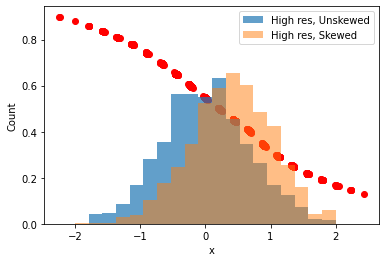

In [25]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,20), alpha=0.7, label="High res, Unskewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,20), alpha=0.5, label="High res, Skewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), classifier.forward(data_test).sigmoid().detach().numpy(), color='red')
plt.show()

# Complete correlation between skewness and resolution (alpha=1)

In [26]:
Nsims = 100
n_balls = 1e2
n_high_steps = 20
n_low_steps = 5
odds_skew = 0.55

g_high_skew = Galton(n_steps=n_high_steps, odds_right=odds_skew, n_dims=1,noise=True) 
g_high_unskew = Galton(n_steps=n_high_steps, odds_right=0.5, n_dims=1,noise=True)
g_low_skew = Galton(n_steps=n_low_steps, odds_right=odds_skew, n_dims=1,noise=True)
g_low_unskew = Galton(n_steps=n_low_steps, odds_right=0.5, n_dims=1,noise=True)

pos_high_skew_arr = np.array([g_high_skew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_high_unskew_arr = np.array([g_high_unskew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_low_skew_arr = np.array([g_low_skew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_low_unskew_arr = np.array([g_low_unskew.simulate(n_balls=n_balls) for _ in range(Nsims)])

#for alpha=1, want complete correlation between resolution and skewness.
data = torch.cat((torch.from_numpy(pos_high_skew_arr).float().reshape(-1,1), torch.from_numpy(pos_low_unskew_arr).float().reshape(-1,1)))
labels = torch.cat([torch.zeros(pos_high_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), torch.ones(pos_low_unskew_arr.shape[0]*pos_low_unskew_arr.shape[1])])

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1) 
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, labels_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

classifier = BinaryClassifier(1, activation="ReLU")
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

In [27]:
#RUN CLASSIFIER
n_steps_train = 10000

classifier.train()
classifier_loss = []
for n_step in trange(n_steps_train):
    data, labels = next(iter(data_generator_train))
    
    optimizer.zero_grad()

    loss = classifier.loss(data, labels).mean()
    classifier_loss.append(loss.item())

    loss.backward()
    optimizer.step()
classifier.eval();
print("Binary Classifier Accuracy: ", ((classifier.forward(data_test) > 0.0) == labels_test).float().mean().item())

100%|██████████| 10000/10000 [00:15<00:00, 632.06it/s]

Binary Classifier Accuracy:  0.7250000238418579


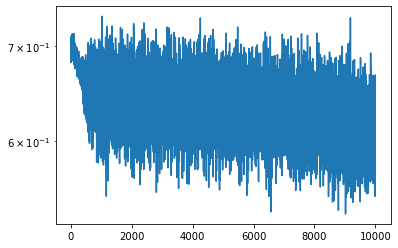

In [28]:
plt.plot(classifier_loss)
plt.yscale('log')

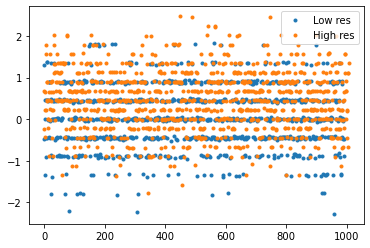

In [29]:
plt.plot(np.array(data_test[labels_test==1]),'.',label="Low res")
plt.plot(np.array(data_test[labels_test==0]), '.', label="High res")
plt.legend()
plt.show()

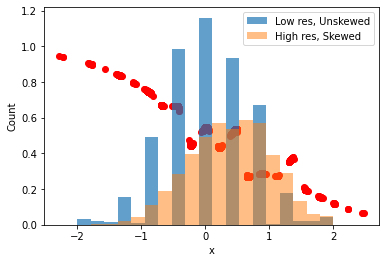

In [30]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,20), alpha=0.7, label="Low res, Unskewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,20),alpha=0.5, label="High res, Skewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), classifier.forward(data_test).sigmoid().detach().numpy(), color='red')

In [31]:
counter_data = torch.cat((torch.from_numpy(pos_low_skew_arr).float().reshape(-1,1), torch.from_numpy(pos_high_unskew_arr).float().reshape(-1,1)))
counter_labels = torch.cat([torch.zeros(pos_low_skew_arr.shape[0]*pos_low_skew_arr.shape[1]), torch.ones(pos_high_unskew_arr.shape[0]*pos_high_unskew_arr.shape[1])])

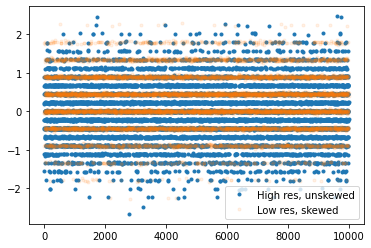

In [32]:
plt.plot(np.array(counter_data[counter_labels==1].reshape(-1,1)),'.',label="High res, unskewed")
plt.plot(np.array(counter_data[counter_labels==0].reshape(-1,1)),'.',label="Low res, skewed", alpha=0.1)
plt.legend()
plt.show()

In [35]:
print("Binary Classifier Accuracy: ", ((classifier.forward(data_test) > 0.0) == labels_test).float().mean().item())
print("Binary Classifier Accuracy With Counter Data: ", ((classifier.forward(counter_data) > 0.0) == counter_labels).float().mean().item())

Binary Classifier Accuracy:  0.7250000238418579
Binary Classifier Accuracy With Counter Data:  0.4034000039100647


## Introducing Fair Flows

### Probability Flow

In [37]:
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=data_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-4, weight_decay=1e-4)

In [38]:
n_steps_prob = 4000
probability_loss = []

probability_flow.train()
for n_step in trange(n_steps_prob):
    data, context = next(iter(data_generator_train))
    context=context.unsqueeze(1)

    # data -= data.min()
    # data /= data.max()

    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())

    loss.backward()
    optimizer.step()
probability_flow.eval();

100%|██████████| 4000/4000 [00:45<00:00, 87.01it/s]


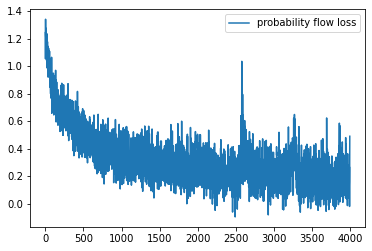

In [39]:
plt.plot(probability_loss, label="probability flow loss")
plt.legend()
plt.show()

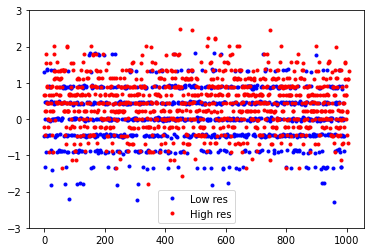

In [40]:
plt.plot(np.array(data_test[labels_test==1]),'b.',label="Low res")
plt.plot(np.array(data_test[labels_test==0]), 'r.', label="High res")
plt.ylim(-3, 3)
plt.legend()

Rational quadratic?

In [41]:
samples = probability_flow._sample(num_samples=1, context=labels_test.unsqueeze(1))

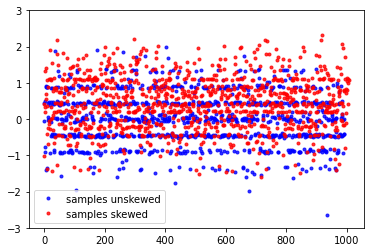

In [42]:
plt.plot(samples.squeeze().detach().numpy()[labels_test.squeeze().numpy()==1], 'b.', alpha=0.8, label="samples unskewed")
plt.plot(samples.squeeze().detach().numpy()[labels_test.squeeze().numpy()==0], 'r.', alpha=0.8, label="samples skewed")
plt.ylim(-3, 3)
plt.legend()

### Fair Normalizing Flows

In [44]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}


data_0 = data_train[labels_train==0]
data_1 = data_train[labels_train==1]
labels_0 = labels_train[labels_train==0]
labels_1 = labels_train[labels_train==1]


# Generators
label_0_set = TensorDataset(data_0, labels_0, labels_0) #labels and context are the same for alpha=1
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1, labels_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)


In [125]:
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
Fairs = []

In [126]:
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=data_train.shape[-1],
                    flow_n_layers = 4,
                    flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 4,
                    classifier_activation = 'ReLU',
                    gamma=gamma
                    )
    optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)

    n_steps = 5000
    Fair.train()
    fair_classifier_loss = []
    for n_step in trange(n_steps):
        data_0, labels_0, context_0 = next(iter(label_0_generator))
        data_1, labels_1, context_1 = next(iter(label_1_generator))

        context_0 = context_0.unsqueeze(1)
        context_1 = context_1.unsqueeze(1)  
        
        optimizer.zero_grad()

        _, _, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

        loss.backward()
        fair_classifier_loss.append(loss.item())
        optimizer.step()
    Fair.eval();

    Fairs.append(Fair)


100%|██████████| 5000/5000 [04:22<00:00, 19.07it/s]


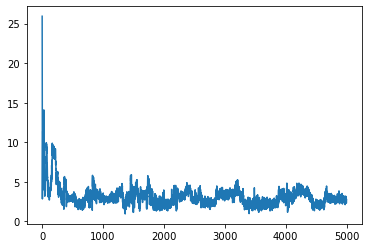

In [127]:
plt.plot(fair_classifier_loss, label="Fair classifier loss")

In [157]:
params

{'batch_size': 64, 'shuffle': True}

In [158]:
idx = labels_test == 0
label_0_test_set = TensorDataset(data_test[idx], labels_test[idx]) #labels and context are the same for alpha=1
label_0_test_generator = torch.utils.data.DataLoader(label_0_test_set, batch_size=min(len(data_test[idx]), len(data_test[~idx])))

label_1_test_set = TensorDataset(data_test[~idx], labels_test[~idx])
label_1_test_generator = torch.utils.data.DataLoader(label_1_test_set,batch_size=min(len(data_test[idx]), len(data_test[~idx])))


In [164]:
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

data_0, context_0 = next(iter(label_0_test_generator))
data_1, context_1 = next(iter(label_1_test_generator))
context_0 = context_0.unsqueeze(1)
context_1 = context_1.unsqueeze(1)

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

# idx = labels_test == 0
# data_0 = data_test[idx]
# data_1 = data_test[~idx]
# context_0 = labels_test[idx]
# context_1 = labels_test[~idx]

# for fair in Fairs:
#     stat_dist, mu0s, mu1s = fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)
#     mu0s_arr.append(mu0s.sum().item()/len(mu0s))
#     mu1s_arr.append(mu1s.sum().item()/len(mu1s))
#     stat_dists.append(abs(stat_dist.item()))
# print(stat_dists)

[1.0, 0.9798589944839478, 0.862034261226654, 0.808660626411438, 0.7341389656066895]


In [130]:
accs = []
for fair in Fairs:
    with torch.no_grad():
        idx = (labels_test == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_test[idx], data_test[~idx])

    acc_test = EmpiricalStatisticalDistance(
        embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
    )
    accs.append(acc_test)

100%|██████████| 100/100 [00:04<00:00, 21.91it/s]


Training set accuracy: 1.000
Test set accuracy: 1.000


100%|██████████| 100/100 [00:04<00:00, 21.22it/s]


Training set accuracy: 0.997
Test set accuracy: 0.997


100%|██████████| 100/100 [00:04<00:00, 21.61it/s]


Training set accuracy: 0.940
Test set accuracy: 0.937


100%|██████████| 100/100 [00:04<00:00, 21.23it/s]


Training set accuracy: 0.924
Test set accuracy: 0.941


100%|██████████| 100/100 [00:04<00:00, 21.15it/s]

Training set accuracy: 0.833
Test set accuracy: 0.794


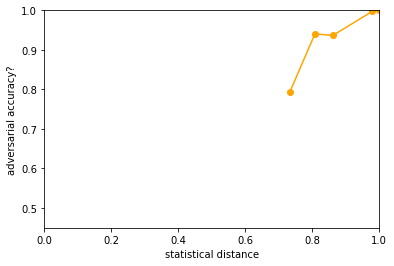

In [165]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy?')
plt.show()

The adversarial accuracy and statistical distance are both high, which makes sense since the data are as correlated as possible. Now let's try with a more fair data set. 
Decisions of label binary classifier on transformed data (one for high, one for low)
Not-totally correlated set
figure out data splitting

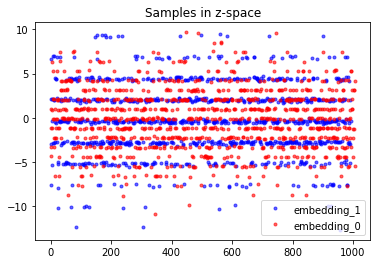

In [132]:
plt.plot(embedding_1.detach().numpy(), 'b.', alpha=0.6, label="embedding_1")
plt.plot(embedding_0.detach().numpy(), 'r.', alpha=0.6, label="embedding_0")
plt.title("Samples in z-space")
plt.legend()
plt.show()

### New Adversarial Classifier

In [182]:
classifiers = []
#RUN CLASSIFIER
n_steps_train = 5000

for fair in Fairs:

    classifier = BinaryClassifier(1, activation="ReLU")
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

    classifier.train()
    classifier_loss = []
    for n_step in trange(n_steps_train):
        data, labels = next(iter(data_generator_train))

        idx = (labels == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data[idx], data[~idx])

        embedded_data = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
        labels = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])])
        
        optimizer.zero_grad()

        loss = classifier.loss(embedded_data, labels).mean()
        classifier_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    classifier.eval();

    idx = (labels_test == 0).flatten()
    embedding_0, embedding_1 = fair._embed(
        data_test[idx], data_test[~idx])
    embedded_data_test = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
    embedded_labels_test = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])])
    print("Binary Classifier Accuracy: ", ((classifier.forward(embedded_data_test) > 0.0) == embedded_labels_test).float().mean().item())

    classifiers.append(classifier)

100%|██████████| 5000/5000 [00:30<00:00, 163.07it/s]


Binary Classifier Accuracy:  1.0


100%|██████████| 5000/5000 [00:29<00:00, 167.32it/s]


Binary Classifier Accuracy:  0.9725000262260437


100%|██████████| 5000/5000 [00:29<00:00, 168.24it/s]


Binary Classifier Accuracy:  0.8884999752044678


100%|██████████| 5000/5000 [00:29<00:00, 168.67it/s]


Binary Classifier Accuracy:  0.862500011920929


100%|██████████| 5000/5000 [00:29<00:00, 167.48it/s]

Binary Classifier Accuracy:  0.7145000100135803


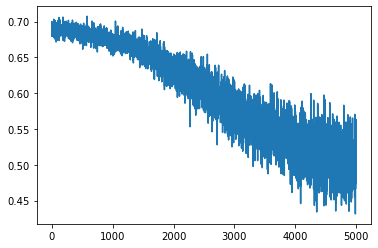

In [183]:
plt.plot(classifier_loss)

In [ ]:
accs_new = []
for i, fair in enumerate(Fairs):
    with torch.no_grad():
        idx = (labels_test == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_test[idx], data_test[~idx])

        embedded_data_test = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
        embedded_labels_test = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])]) 

        acc_test = ((classifiers[i].forward(embedded_data_test) > 0.0) == embedded_labels_test).float().mean().item()

    accs_new.append(acc_test)

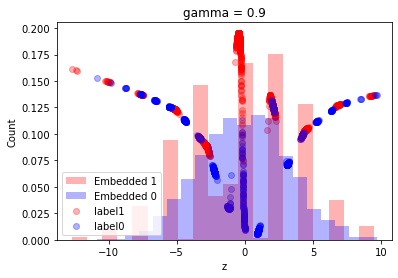

In [256]:
gamma_idx = 4
with torch.no_grad():
    idx = (labels_test == 0).flatten()
    embedded_data_test_0, embedded_data_test_1 = Fairs[gamma_idx]._embed(
        data_test[idx], data_test[~idx])
    # embedded_data_test_1 = embedded_data_test[embedded_labels_test==1]
    # embedded_data_test_0 = embedded_data_test[embedded_labels_test==0]

    plt.hist(np.array(embedded_data_test_1), bins=20, alpha=0.3, label="Embedded 1", density=True, color='red')
    plt.hist(np.array(embedded_data_test_0), bins=20, alpha=0.3, label="Embedded 0", density=True, color='blue')
    plt.xlabel("z")
    plt.ylabel("Count")
    plt.scatter(embedded_data_test_1, classifiers[gamma_idx].forward(embedded_data_test_1).sigmoid()/5, color='red', label='label1', alpha=0.3)
    plt.scatter(embedded_data_test_0, classifiers[gamma_idx].forward(embedded_data_test_0).sigmoid()/5, color='blue', label='label0', alpha=0.3)
    plt.legend(loc='lower left')
    plt.title('gamma = {}'.format(gammas[gamma_idx]))
    # plt.savefig('Figures/galton_embedding_gamma_{}.png'.format(gammas[gamma_idx]))


In [196]:
accs_new = []
for i, fair in enumerate(Fairs):
    with torch.no_grad():
        idx = (labels_test == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_test[idx], data_test[~idx])

        embedded_data_test = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
        embedded_labels_test = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])]) 

        acc_test = ((classifiers[i].forward(embedded_data_test) > 0.0) == embedded_labels_test).float().mean().item()

    accs_new.append(acc_test)

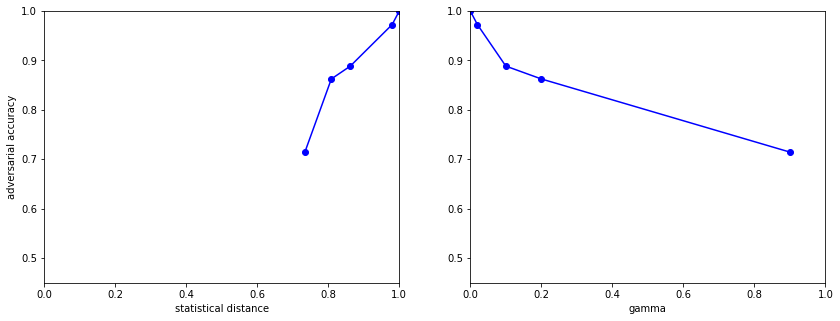

In [224]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
# plt.plot(stat_dists, accs, '-o', color='orange')
plt.plot(stat_dists, accs_new, '-o', color='blue')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy')

plt.subplot(1,2,2)
# plt.plot(gammas, accs, '-o', color='orange')
plt.plot(gammas, accs_new, '-o', color='blue')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('gamma')
# plt.ylabel('adversarial accuracy')
# plt.savefig('Figures/galton_embedding_gamma_acc.png')
plt.show()


Try gamma = 0.99. Does it smooth?
Use UMNN? Infinte flexibility.

# alpha = 0.5. Partial correlation

In [2]:
Nsims = 100
Nsims2 = 50
n_balls = 1e2
n_high_steps = 20
n_low_steps = 5
odds_skew = 0.55

g_high_skew = Galton(n_steps=n_high_steps, odds_right=odds_skew, n_dims=1,noise=True) 
g_high_unskew = Galton(n_steps=n_high_steps, odds_right=0.5, n_dims=1,noise=True)
g_low_skew = Galton(n_steps=n_low_steps, odds_right=odds_skew, n_dims=1,noise=True)
g_low_unskew = Galton(n_steps=n_low_steps, odds_right=0.5, n_dims=1,noise=True)

pos_high_skew_arr = np.array([g_high_skew.simulate(n_balls=n_balls) for _ in range(Nsims)])
pos_high_unskew_arr = np.array([g_high_unskew.simulate(n_balls=n_balls) for _ in range(Nsims2)])
pos_low_skew_arr = np.array([g_low_skew.simulate(n_balls=n_balls) for _ in range(Nsims2)])
pos_low_unskew_arr = np.array([g_low_unskew.simulate(n_balls=n_balls) for _ in range(Nsims)])

data = torch.cat((torch.from_numpy(pos_high_skew_arr).float().reshape(-1,1), 
torch.from_numpy(pos_low_skew_arr).float().reshape(-1,1),
torch.from_numpy(pos_low_unskew_arr).float().reshape(-1,1),
torch.from_numpy(pos_high_unskew_arr).float().reshape(-1,1)))

labels = torch.cat([torch.zeros(pos_high_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), 
torch.zeros(pos_low_skew_arr.shape[0]*pos_low_skew_arr.shape[1]), 
torch.ones(pos_low_unskew_arr.shape[0]*pos_low_unskew_arr.shape[1]), 
torch.ones(pos_high_unskew_arr.shape[0]*pos_high_unskew_arr.shape[1])])

context = torch.cat([torch.ones(pos_high_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), 
torch.zeros(pos_low_skew_arr.shape[0]*pos_high_skew_arr.shape[1]), 
torch.zeros(pos_low_unskew_arr.shape[0]*pos_low_unskew_arr.shape[1]), 
torch.ones(pos_high_unskew_arr.shape[0]*pos_high_unskew_arr.shape[1])])

data_train, data_test, labels_train, labels_test, context_train, context_test = train_test_split(data, labels, context, test_size=0.1) 
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Generators
data_set_train = TensorDataset(data_train, labels_train, context_train)
data_generator_train = torch.utils.data.DataLoader(data_set_train, **params)

classifier = BinaryClassifier(1, activation="ReLU")
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

In [138]:
#RUN CLASSIFIER
n_steps_train = 10000

classifier.train()
classifier_loss = []
for n_step in trange(n_steps_train):
    data, labels, _ = next(iter(data_generator_train))
    
    optimizer.zero_grad()

    loss = classifier.loss(data, labels).mean()
    classifier_loss.append(loss.item())

    loss.backward()
    optimizer.step()
classifier.eval();
print("Binary Classifier Accuracy: ", ((classifier.forward(data_test) > 0.0) == labels_test).float().mean().item())

100%|██████████| 10000/10000 [00:24<00:00, 403.77it/s]

Binary Classifier Accuracy:  0.5920000076293945


In [3]:
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=data_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-4, weight_decay=1e-4)

In [4]:
n_steps_prob = 2000
probability_loss = []

probability_flow.train()
for n_step in trange(n_steps_prob):
    data, labels, context = next(iter(data_generator_train))
    context=context.unsqueeze(1)

    # data -= data.min()
    # data /= data.max()

    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())

    loss.backward()
    optimizer.step()
probability_flow.eval();

100%|██████████| 2000/2000 [00:24<00:00, 80.05it/s]


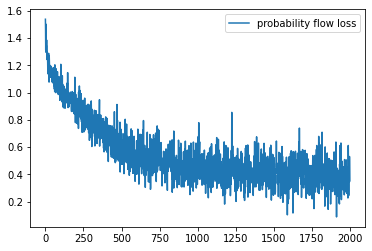

In [5]:
plt.plot(probability_loss, label="probability flow loss")
plt.legend()
plt.show()

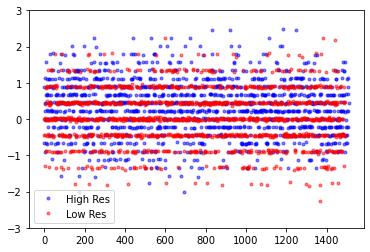

In [6]:
plt.plot(np.array(data_test[context_test==1]),'b.',label="High Res", alpha=0.5)
plt.plot(np.array(data_test[context_test==0]), 'r.', label="Low Res", alpha=0.5)
# plt.plot(np.array(data_test[labels_test==1]),'b.',label="Unskewed", alpha=0.5)
# plt.plot(np.array(data_test[labels_test==0]), 'r.', label="Skewed", alpha=0.5)
plt.ylim(-3, 3)
plt.legend()
plt.show()

In [7]:
samples = probability_flow._sample(num_samples=1, context=context_test.unsqueeze(1))

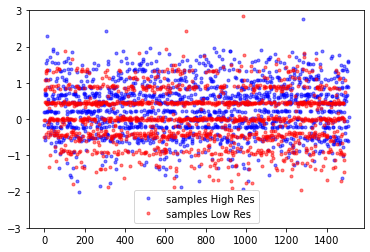

In [8]:
plt.plot(samples.squeeze().detach().numpy()[context_test.squeeze().numpy()==1], 'b.', alpha=0.5, label="samples High Res")
plt.plot(samples.squeeze().detach().numpy()[context_test.squeeze().numpy()==0], 'r.', alpha=0.5, label="samples Low Res")
plt.ylim(-3, 3)
plt.legend()
plt.show()

In [5]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}


data_0 = data_train[context_train==0]
data_1 = data_train[context_train==1]
labels_0 = labels_train[context_train==0]
labels_1 = labels_train[context_train==1]
context_0 = labels_train[context_train==0]
context_1 = labels_train[context_train==1]


# Generators
label_0_set = TensorDataset(data_0, labels_0, context_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1, context_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)


In [10]:
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
Fairs = []

In [11]:
for gamma in gammas:
    # Fair = BinaryFair(data_dim=data_train.shape[-1], 
    #                 context_dim=data_train.shape[-1],
    #                 flow_n_layers = 4,
    #                 flow_transform_type = 'MaskedAffineAutoregressiveTransform', #! Try UMNN 
    #                 classifier_hidden_dim = 32,
    #                 classifier_n_layers = 4,
    #                 classifier_activation = 'ReLU',
    #                 gamma=gamma
    #                 )
    Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=data_train.shape[-1],
                    flow_n_layers = 4,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 4,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
    optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)

    n_steps = 4000
    Fair.train()
    fair_classifier_loss = []
    for n_step in trange(n_steps):
        data_0, labels_0, context_0 = next(iter(label_0_generator))
        data_1, labels_1, context_1 = next(iter(label_1_generator))

        context_0 = context_0.unsqueeze(1)
        context_1 = context_1.unsqueeze(1)  
        
        optimizer.zero_grad()

        _, _, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

        loss.backward()
        fair_classifier_loss.append(loss.item())
        optimizer.step()
    Fair.eval();

    Fairs.append(Fair)


  5%|▌         | 204/4000 [00:05<01:40, 37.63it/s]

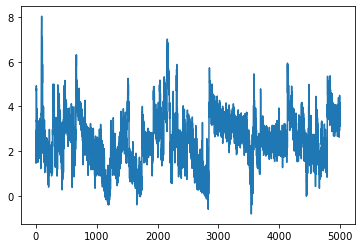

In [ ]:
plt.plot(fair_classifier_loss, label="Fair flows loss")
plt.show()

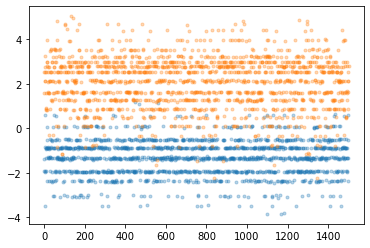

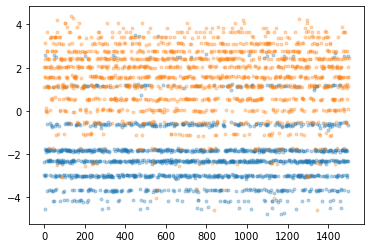

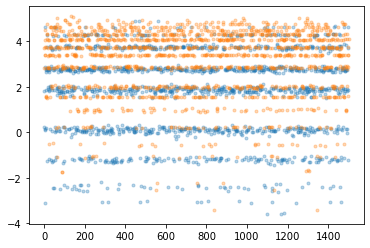

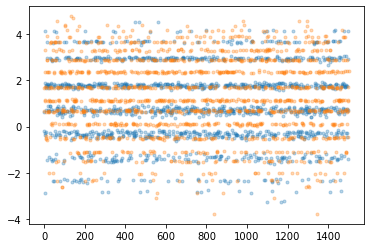

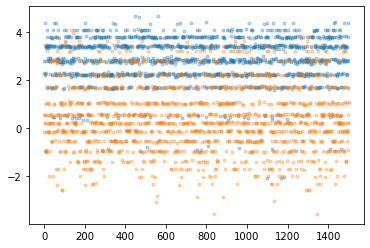

In [ ]:
for i, fair in enumerate(Fairs):
    with torch.no_grad():
        idx = (context_test == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_test[idx], data_test[~idx])

        plt.figure()
        plt.plot(embedding_0,'.', alpha=0.3)
        plt.plot(embedding_1,'.', alpha=0.3)

In [173]:
idx = context_test == 0
label_0_test_set = TensorDataset(data_test[idx], context_test[idx]) 
label_0_test_generator = torch.utils.data.DataLoader(label_0_test_set, batch_size=min(len(data_test[idx]), len(data_test[~idx])))

label_1_test_set = TensorDataset(data_test[~idx], context_test[~idx])
label_1_test_generator = torch.utils.data.DataLoader(label_1_test_set,batch_size=min(len(data_test[idx]), len(data_test[~idx])))


In [191]:
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

data_0, context_0 = next(iter(label_0_test_generator))
data_1, context_1 = next(iter(label_1_test_generator))
context_0 = context_0.unsqueeze(1)
context_1 = context_1.unsqueeze(1)

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)


[0.8969696760177612, 0.5562289357185364, 0.4653198719024658, 0.4814814627170563, 0.4659932255744934]


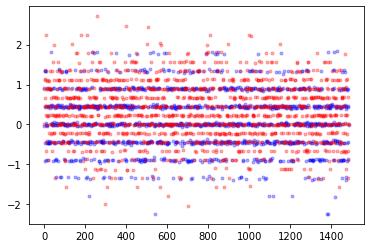

In [196]:
plt.plot(data_0,'b.',alpha=0.3)
plt.plot(data_1,'r.',alpha=0.3)

In [175]:
#Adversarial classifiers
classifiers = []
#RUN CLASSIFIER
n_steps_train = 2000

for fair in Fairs:

    classifier = BinaryClassifier(1, activation="ReLU")
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

    classifier.train()
    classifier_loss = []
    for n_step in trange(n_steps_train):
        data, labels, context = next(iter(data_generator_train))

        idx = (context == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data[idx], data[~idx])

        embedded_data = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
        context = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])])
        
        optimizer.zero_grad()

        loss = classifier.loss(embedded_data, context).mean()
        classifier_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    classifier.eval();

    idx = (context_test == 0).flatten()
    embedding_0, embedding_1 = fair._embed(
        data_test[idx], data_test[~idx])
    embedded_data_test = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
    embedded_context_test = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])])
    print("Adversarial Classifier Accuracy: ", ((classifier.forward(embedded_data_test) > 0.0) == embedded_context_test).float().mean().item())

    classifiers.append(classifier)

100%|██████████| 2000/2000 [00:15<00:00, 129.00it/s]


Binary Classifier Accuracy:  0.9556666612625122


100%|██████████| 2000/2000 [00:15<00:00, 128.42it/s]


Binary Classifier Accuracy:  0.6880000233650208


100%|██████████| 2000/2000 [00:16<00:00, 120.97it/s]


Binary Classifier Accuracy:  0.6349999904632568


100%|██████████| 2000/2000 [00:16<00:00, 121.74it/s]


Binary Classifier Accuracy:  0.57833331823349


100%|██████████| 2000/2000 [00:16<00:00, 124.06it/s]

Binary Classifier Accuracy:  0.6183333396911621


In [176]:
accs_new = []
for i, fair in enumerate(Fairs):
    with torch.no_grad():
        idx = (context_test == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_test[idx], data_test[~idx])

        embedded_data_test = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
        embedded_context_test = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])]) 

        acc_test = ((classifiers[i].forward(embedded_data_test) > 0.0) == embedded_context_test).float().mean().item()

    accs_new.append(acc_test)

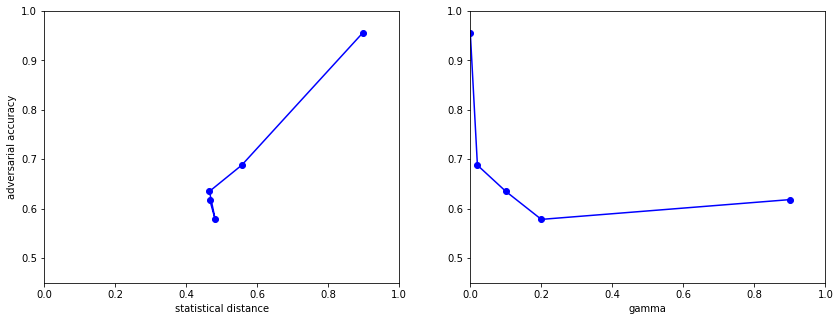

In [177]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
# plt.plot(stat_dists, accs, '-o', color='orange')
plt.plot(stat_dists, accs_new, '-o', color='blue')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy')

plt.subplot(1,2,2)
# plt.plot(gammas, accs, '-o', color='orange')
plt.plot(gammas, accs_new, '-o', color='blue')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('gamma')
# plt.ylabel('adversarial accuracy')
# plt.savefig('Figures/galton_embedding_gamma_acc.png')
plt.show()


In [178]:
#Label classifiers
label_classifiers = []
#RUN CLASSIFIER
n_steps_train = 2000

for fair in Fairs:

    classifier = BinaryClassifier(1, activation="ReLU")
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

    classifier.train()
    classifier_loss = []
    for n_step in trange(n_steps_train):
        data, labels, context = next(iter(data_generator_train))

        idx = (context == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data[idx], data[~idx])

        embedded_data = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
        # labels = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])])
        labels = torch.cat([labels[idx], labels[~idx]])
        
        optimizer.zero_grad()

        loss = classifier.loss(embedded_data, labels).mean()
        classifier_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    classifier.eval();

    idx = (context_test == 0).flatten()
    embedding_0, embedding_1 = fair._embed(
        data_test[idx], data_test[~idx])
    embedded_data_test = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
    embedded_labels_test = torch.cat([labels_test[idx], labels_test[~idx]])
    print("Binary Classifier Accuracy: ", ((classifier.forward(embedded_data_test) > 0.0) == embedded_labels_test).float().mean().item())

    label_classifiers.append(classifier)

100%|██████████| 2000/2000 [00:16<00:00, 124.73it/s]


Binary Classifier Accuracy:  0.6850000023841858


100%|██████████| 2000/2000 [00:15<00:00, 128.56it/s]


Binary Classifier Accuracy:  0.6293333172798157


100%|██████████| 2000/2000 [00:16<00:00, 123.63it/s]


Binary Classifier Accuracy:  0.5920000076293945


100%|██████████| 2000/2000 [00:15<00:00, 125.65it/s]


Binary Classifier Accuracy:  0.5839999914169312


100%|██████████| 2000/2000 [00:15<00:00, 125.65it/s]


Binary Classifier Accuracy:  0.5920000076293945


In [179]:
label_accs_new = []
for i, fair in enumerate(Fairs):
    with torch.no_grad():
        idx = (context_test == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_test[idx], data_test[~idx])

        embedded_data_test = torch.cat([embedding_0, embedding_1], dim=0) # Do I need to randomize these?
        embedded_labels_test = torch.cat([labels_test[idx], labels_test[~idx]])

        label_acc_test = ((label_classifiers[i].forward(embedded_data_test) > 0.0) == embedded_labels_test).float().mean().item()

    label_accs_new.append(label_acc_test)

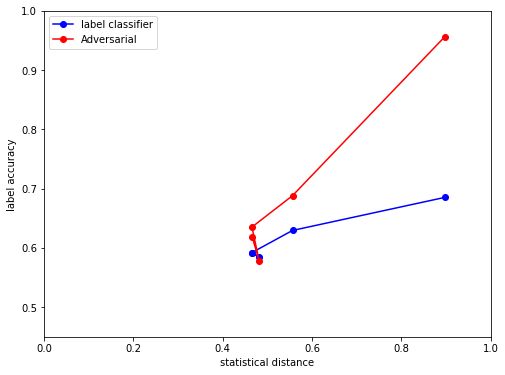

In [180]:
plt.figure(figsize=(8,6))
# plt.subplot(1,2,1)
# plt.plot(stat_dists, accs, '-o', color='orange')
plt.plot(stat_dists, label_accs_new, '-o', color='blue', label='label classifier')
plt.plot(stat_dists, accs_new, '-o', color='red', label='Adversarial')

plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('label accuracy')

# plt.subplot(1,2,2)
# # plt.plot(gammas, accs, '-o', color='orange')
# plt.plot(gammas, label_accs_new, '-o', color='blue')
# plt.xlim(0,1)
# plt.ylim(0.45,1)
# plt.xlabel('gamma')
# # plt.ylabel('adversarial accuracy')
# # plt.savefig('Figures/galton_embedding_gamma_acc.png')
plt.legend()
plt.show()


# Splitting Samples (Not working)

In [249]:
def split_samples(alpha, beta, samples0_0, samples0_1, samples1_0, samples1_1):
    """
    Calculate the number of samples from each probability for a given alpha, beta, and Ntot in order to have equal numbers of samples from
    each resolution (assuming n_prob1_highres = n_prob1_lowres, n_prob2_highres = n_prob2_lowres)

    Inputs: 
    alpha - label splitting parameter
    beta - sensitive attribute splitting parameter
    Ntot - total number of samples
    samples0_0 - samples from the first probability with sensitive attribute 0
    samples0_1 - samples from the first probability with sensitive attribute 1
    samples1_0 - samples from the second probability with sensitive attribute 0
    samples1_1 - samples from the second probability with sensitive attribute 1

    Returns: total samples
    """
    if len(samples0_0) != len(samples0_1) or len(samples0_0) != len(samples1_0) or len(samples0_0) != len(samples1_1) or \
    len(samples0_1) != len(samples1_0) or len(samples0_1) != len(samples1_1) or len(samples1_0) != len(samples1_1):
        print("Error: the number of samples from each probability must be the same")
        return 0

    n = len(samples0_0) 

    samples_low = np.concatenate((np.random.choice(samples0_0, round(n*alpha)), np.random.choice(samples1_0, round(n*(1-alpha)))))
    
    samples_high = np.concatenate((np.random.choice(samples0_1, round(n*alpha)), np.random.choice(samples1_1, round(n*(1-alpha)))))

    samples_tot = np.concatenate((np.random.choice(samples_low, round(n*beta)), np.random.choice(samples_high, round(n*(1-beta)))))
    
    return samples_tot

In [250]:
samples0_0 = np.random.uniform(0,1,10)
samples0_1 = np.random.uniform(0,1,10)
samples1_0 = np.random.uniform(-1,0,10)
samples1_1 = np.random.uniform(-1,0,10)

split_samples(0.5, 0.5, samples0_0, samples0_1, samples1_0, samples1_1)

array([-0.16368915,  0.12314658, -0.19718988, -0.19718988,  0.12314658,
        0.41154107,  0.18569382,  0.41154107,  0.01859128, -0.93851458])

<!-- run N dimensional galton board. Independent runs -->
Testing 
Run binary classifier to see if skewed
plot classifier output vs x for relative resolutions

In [258]:
#     #! This version is outdated I think
# def label_sample_split(alpha, beta, Ntot, samples0_0, samples0_1, samples1_0, samples1_1):
#     """
#     Calculate the number of samples from each probability for a given alpha, beta, and Ntot in order to have equal numbers of samples from
#     each resolution (assuming n_prob1_highres = n_prob1_lowres, n_prob2_highres = n_prob2_lowres)

#     Inputs: 
#     alpha - label splitting parameter
#     beta - sensitive attribute splitting parameter
#     Ntot - total number of samples
#     samples0_0 - samples from the first probability with sensitive attribute 0
#     samples0_1 - samples from the first probability with sensitive attribute 1
#     samples1_0 - samples from the second probability with sensitive attribute 0
#     samples1_1 - samples from the second probability with sensitive attribute 1

#     Returns: total samples
#     """

#     #todo: add special cases for alpha = 0 and beta = 0 etc.

#     # if alpha==0.5: #All samples are from the first probability
#     #     n0 = Ntot/2
#     #     n1 = 0
#     # elif beta==1: #All samples are from the first sensitive attribute
#     #     n0 = samples0_0
#     #     n1 = samples0_1
#     # elif beta==0: #All samples are from the second sensitive attribute
#     #     n0 = samples1_0
#     #     n1 = samples1_1
#     # else:
#     n0 = Ntot*(1 - alpha - beta) / (2.0*(2*alpha-1)*(beta**2 - beta))
#     n1 = n0 * (alpha-beta)/(alpha + beta - 1)

#     data_0 = np.concatenate((np.random.choice(samples0_0, round(n0*alpha)), np.random.choice(samples1_0, round(n1*(1-alpha))))) #data with sensitive attribute 0
#     data_1 = np.concatenate((np.random.choice(samples0_1, round(n0*(1-alpha))), np.random.choice(samples1_1, round(n1*alpha)))) #data with sensitive attribute 1


#     return np.concatenate((np.random.choice(data_0,round(beta*Ntot)), np.random.choice(data_1,round((1-beta)*Ntot))))

sensitive: number of steps
label: probablities
4 boards, equally weighted. Fraction of 50/50 high res.

num5050 = num6040


<!-- Not these!! -->
<!-- num5050_30 = num5050_5
num6040_30 = num6040_5 -->

datansteps30 = (alpha)num505030 + (1-alpha)num604030
datansteps5 = (1-alpha)num50505 + (alpha)num60405

<!-- datansteps30 = (alpha)num505030 + (1-alpha)num604030
datansteps5 = (alpha)num50505 + (1-alpha)num60405 -->

datatot = (beta)datansteps30 + (1-beta)datansteps5

datatot needs to have equal numbers of 5050 vs 6040 samples

In [ ]:
beta*(alpha*num_50 + (1-alpha)num_60) = (1-beta)((1-alpha)num_50 + (alpha)num_60)

Create a dataset that has certain values of alpha and beta
alpha=1 (completely correlated. See if it can classify the opposite case)
alpha=0.5 case?